In [39]:
import pandas as pd
from utils.utils import *

df = pd.read_json('../data/complaints.json')

## Load and Inspect Data

In [20]:
df.head()

,_index,_type,_id,_score,_source
0,complaint-public-v2,complaint,3211475,0,"{'tags': None, 'zip_code': '90301', 'complaint..."
1,complaint-public-v2,complaint,3229299,0,"{'tags': 'Servicemember', 'zip_code': '319XX',..."
2,complaint-public-v2,complaint,3199379,0,"{'tags': None, 'zip_code': '77069', 'complaint..."
3,complaint-public-v2,complaint,2673060,0,"{'tags': None, 'zip_code': '48066', 'complaint..."
4,complaint-public-v2,complaint,3203545,0,"{'tags': None, 'zip_code': '10473', 'complaint..."


In [35]:
new_df = pd.json_normalize(df['_source'])
new_df = new_df[~(new_df['complaint_what_happened'] == '')]

In [36]:
new_df.head(3)

,tags,zip_code,complaint_id,issue,date_received,state,consumer_disputed,product,company_response,company,submitted_via,date_sent_to_company,company_public_response,sub_product,timely,complaint_what_happened,sub_issue,consumer_consent_provided
1,Servicemember,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,GA,N/A,Debt collection,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,Good morning my name is XXXX XXXX and I apprec...,Didn't receive enough information to verify debt,Consent provided
2,None,77069,3199379,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,TX,N/A,Credit card or prepaid card,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-02T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Problem with rewards from credit card,Consent provided
10,None,104XX,3233499,Incorrect information on your report,2019-05-06T12:00:00-05:00,NY,N/A,"Credit reporting, credit repair services, or o...",Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-06T12:00:00-05:00,None,Other personal consumer report,Yes,Chase Card was reported on XX/XX/2019. However...,Information belongs to someone else,Consent provided


In [34]:
pd.unique(new_df.sub_product)

array(['Credit card debt', 'General-purpose credit card or charge card',
       'Other personal consumer report', 'Credit reporting',
       'Checking account', 'Loan', 'Domestic (US) money transfer',
       'Savings account', 'Conventional home mortgage',
       'Home equity loan or line of credit (HELOC)',
       'Private student loan', 'I do not know', 'Vehicle loan',
       'FHA mortgage', 'Mobile or digital wallet', 'Virtual currency',
       'VA mortgage', 'Other type of mortgage',
       'International money transfer', 'Lease', 'Store credit card',
       'Check cashing service', 'Other banking product or service',
       'General-purpose prepaid card', 'Personal line of credit',
       'Credit repair services', 'Foreign currency exchange',
       'Other debt', None, 'Home equity loan or line of credit',
       'Installment loan', 'Other bank product/service',
       'Other (i.e. phone, health club, etc.)', 'Credit card',
       'Conventional adjustable mortgage (ARM)', 'Other m

In [53]:
complaints_df = new_df[['complaint_id', 'complaint_what_happened']]
complaints_df.head()

,complaint_id,complaint_what_happened
1,3229299,Good morning my name is XXXX XXXX and I apprec...
2,3199379,I upgraded my XXXX XXXX card in XX/XX/2018 and...
10,3233499,Chase Card was reported on XX/XX/2019. However...
11,3180294,"On XX/XX/2018, while trying to book a XXXX XX..."
14,3224980,my grand son give me check for {$1600.00} i de...


## Process Data

In [54]:
complaints_df.rename(columns={'complaint_what_happened': 'complaint'}, inplace=True)

/tmp/ipykernel_3907/2811723167.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  complaints_df.rename(columns={'complaint_what_happened': 'complaint'}, inplace=True)


In [55]:
complaints_df.head()

,complaint_id,complaint
1,3229299,Good morning my name is XXXX XXXX and I apprec...
2,3199379,I upgraded my XXXX XXXX card in XX/XX/2018 and...
10,3233499,Chase Card was reported on XX/XX/2019. However...
11,3180294,"On XX/XX/2018, while trying to book a XXXX XX..."
14,3224980,my grand son give me check for {$1600.00} i de...
...,...,...
78303,3094545,After being a Chase Card customer for well ove...
78309,3091984,"On Wednesday, XX/XX/XXXX I called Chas, my XXX..."
78310,3133355,I am not familiar with XXXX pay and did not un...
78311,3110963,I have had flawless credit for 30 yrs. I've ha...


In [56]:
complaints_df['complaint'] = complaints_df['complaint'].apply(clean)

/tmp/ipykernel_3907/1348463555.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  complaints_df['complaint'] = complaints_df['complaint'].apply(clean)


In [57]:
complaints_df.head()

,complaint_id,complaint
1,3229299,good morning my name is and i appreciate it ...
2,3199379,i upgraded my card in and was told by the a...
10,3233499,chase card was reported on however fraudulent...
11,3180294,on while trying to book a ticket i came a...
14,3224980,my grand son give me check for i deposit it i...


In [94]:
text = complaints_df['complaint'].apply(noun_extraction)

In [235]:
complaints_df.loc[:, 'clean_text'] = text

In [95]:
pipe = vectorizer_pipeline(text)

**Topics**
1. Credit card / Prepaid card
2. Mortgages/loans
3. Others
4. Bank account services
5. Theft / Dispute reporting

In [191]:
topic_map = {
    0: 'Credit card / Prepaid card',
    1: 'Mortgages/loans',
    2: 'Others',
    3: 'Bank account services',
    4: 'Theft / Dispute reporting'
}

In [189]:
topic_term_matrix = pipe['nmf'].components_
words = pipe['count'].get_feature_names_out()

topics = [['']*5 for _ in range(5)]
for i in range(5):
    index = topic_term_matrix[i].argsort()[::-1][:5]
    topics[i] = words[index]

topic_words = pd.DataFrame(topics, index=[f'Word {i}' for i in range(1, 6)], columns=[topic_map[i] for i in range(5)])

In [190]:
topic_words

,Credit card / Prepaid card,Mortgages/loans,Others,Bank account services,Theft / Dispute reporting
Word 1,account,bank,money,check,chase
Word 2,card,chase,credit,charge,dispute
Word 3,loan,mortgage,chase,home,modification
Word 4,credit,report,inquiry,score,debt
Word 5,payment,balance,interest,month,statement


In [196]:
nmf_output = pipe['nmf'].transform(
    pipe['tfidf'].transform(pipe['count'].transform(text))
)

cluster_assignments = np.argmax(nmf_output, axis=1)
complaints_df.loc[:, 'label'] = cluster_assignments
complaints_df.loc[:, 'topic'] = complaints_df['label'].map(topic_map)

In [197]:
complaints_df.head()

,complaint_id,complaint,label,topic
1,3229299,good morning my name is and i appreciate it ...,0,Credit card / Prepaid card
2,3199379,i upgraded my card in and was told by the a...,1,Mortgages/loans
10,3233499,chase card was reported on however fraudulent...,3,Bank account services
11,3180294,on while trying to book a ticket i came a...,3,Bank account services
14,3224980,my grand son give me check for i deposit it i...,0,Credit card / Prepaid card


In [236]:
topic_dfs = {
    topic_map[label]: complaints_df[complaints_df['label'] == label] \
    for label in topic_map
}

In [206]:
feature_names = pipe['count'].get_feature_names_out()
word_counts = pipe['count'].transform(text).sum(axis=0)

word_counts_df = pd.DataFrame({
    'Word': feature_names, 
    'Count': word_counts.tolist()[0]
}).sort_values(by='Count', ascending=False)

word_counts_df.head()

,Word,Count
2279,chase,51647
96,account,41006
3345,credit,32683
1161,bank,26662
1955,card,26010


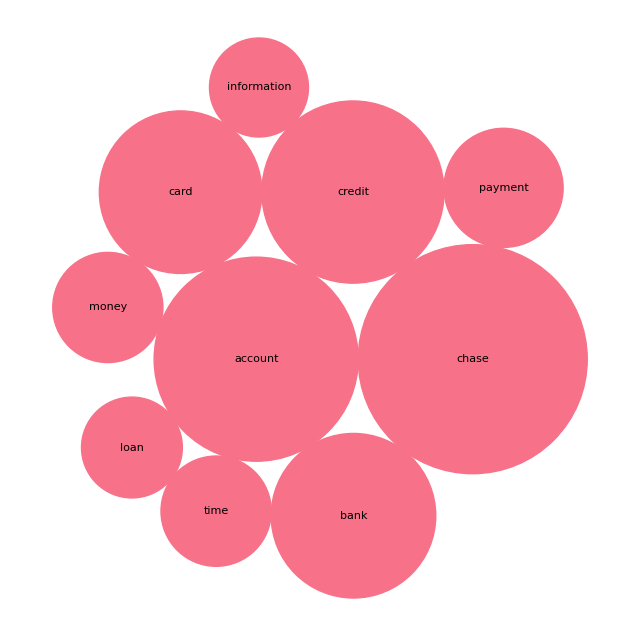

In [130]:
import circlify as circ
import matplotlib.pyplot as plt
import seaborn as sns

edge = sns.color_palette('husl')[0]
face = sns.color_palette('husl')[0]

k = 10
data = word_counts_df[word_counts_df.Count > 0]
values = data['Count'].values.tolist()[:k]
labels = data['Word'].values.tolist()[:k][::-1]

# Generate circular packing using circlify
circles = circ.circlify(values, show_enclosure=True, target_enclosure=circ.Circle(0, 0, 1))

# Plot the circles with annotations
fig, ax = plt.subplots(figsize=(8, 8))

for circle, label in zip(circles, labels):
    x, y, r = circle.circle
    plt.gca().add_patch(plt.Circle((x, y), r, fill=True, edgecolor=edge, facecolor=face))
    plt.text(x, y, label, ha='center', va='center', fontsize=8)

plt.axis('equal')
plt.axis('off')
plt.show()


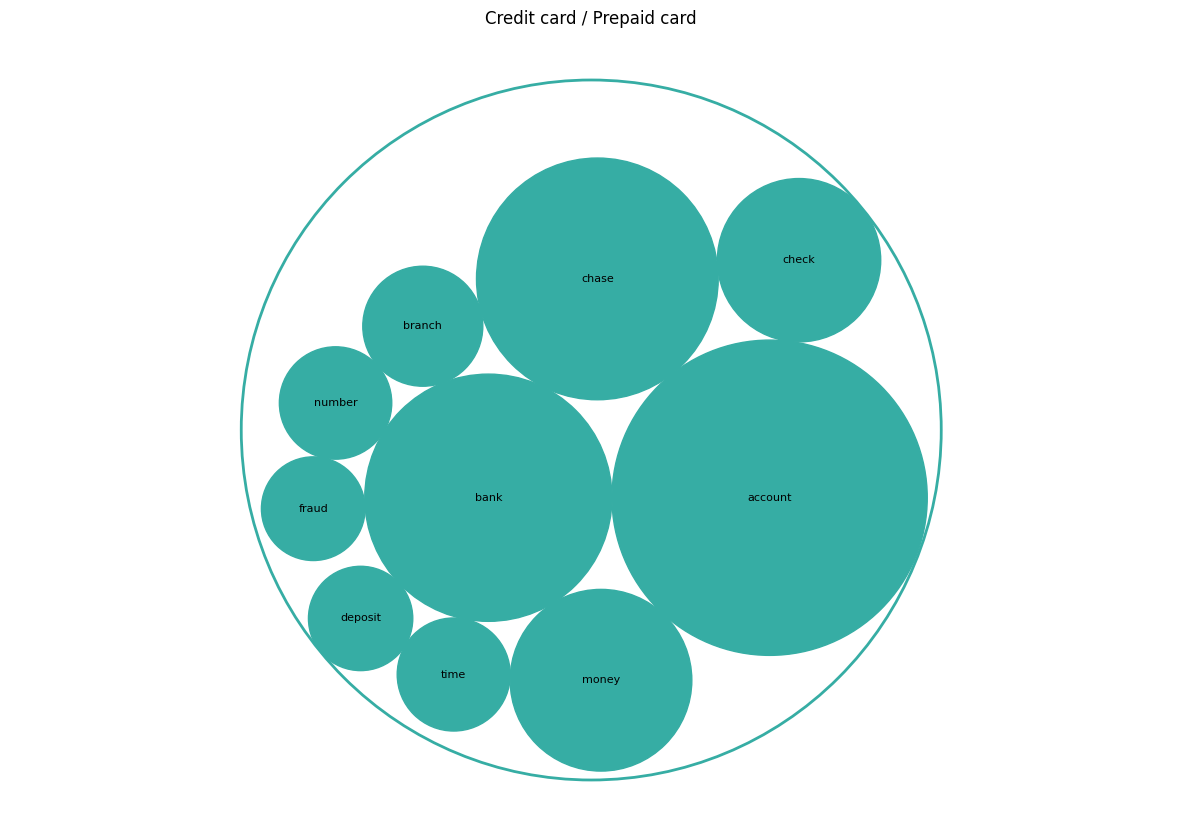

In [266]:
import circlify as circ
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming you're working with the first topic (index 0)
# topic = 'Theft / Dispute reporting'
fig, ax = plt.subplots(figsize=(15, 10))
offset = 2.5
positions = [(0, 0), (offset, 0), (-offset, 0), (0, offset), (0, -offset)]

for topic, position in zip(topic_map.values(), positions):
    data = topic_dfs[topic]
    feature_names = pipe['count'].get_feature_names_out()
    word_counts = pipe['count'].transform(data['clean_text']).sum(axis=0)

    topic_data = pd.DataFrame({
        'Word': feature_names, 
        'Count': word_counts.tolist()[0]
    }).sort_values(by='Count', ascending=False)


    values = topic_data['Count'].values.tolist()[:k]
    labels = topic_data['Word'].values.tolist()[:k][::-1]

    edge = sns.color_palette('husl')[3]
    face = sns.color_palette('husl')[3]

    # Generate circular packing using circlify
    circles = circ.circlify(values, show_enclosure=True, target_enclosure=None)

    # Draw the big circle encompassing all k words
    big_circle = circles[0]
    x, y, r = big_circle.circle
    plt.gca().add_patch(plt.Circle((x+position[0], y+position[1]), r, fill=False, edgecolor=edge, linewidth=2))
    plt.text(x+position[0], y+position[1]+1.2, topic, ha='center', va='top', fontsize=12, color='black')

    for circle, label in zip(circles[1:], labels):
        x, y, r = circle.circle
        plt.gca().add_patch(plt.Circle((x+position[0], y+position[1]), r, fill=True, edgecolor=edge, facecolor=face))
        plt.text(x+position[0], y+position[1], label, ha='center', va='center', fontsize=8)
    
    break

    # break

plt.axis('equal')
plt.axis('off')
plt.show()
